## More Complex Regressions
### Dream Team

In [1]:
]activate proxgrad

 Activating new environment at `C:\Users\darre\Documents\_cornell 20-21\orie 4741\dream-team\proxgrad models\proxgrad\Project.toml`


In [4]:
using Pkg
# Pkg.add("LowRankModels")

   Updating registry at `C:\Users\darre\.julia\registries\General`
  Resolving package versions...
  Installed NaNMath ──────────────── v0.3.5
  Installed PositiveFactorizations ─ v0.2.4
  Installed DiffRules ────────────── v1.0.2
  Installed Requires ─────────────── v1.1.1
Updating `C:\Users\darre\Documents\_cornell 20-21\orie 4741\dream-team\proxgrad models\proxgrad\Project.toml`
  [15d4e49f] + LowRankModels v1.1.1
Updating `C:\Users\darre\Documents\_cornell 20-21\orie 4741\dream-team\proxgrad models\proxgrad\Manifest.toml`
  [7d9fca2a] + Arpack v0.4.0
  [68821587] + Arpack_jll v3.5.0+3
  [4fba245c] + ArrayInterface v2.13.7
  [56f22d72] + Artifacts v1.3.0
  [324d7699] + CategoricalArrays v0.8.3
  [bbf7d656] + CommonSubexpressions v0.3.0
  [34da2185] + Compat v3.23.0
  [e66e0078] + CompilerSupportLibraries_jll v0.3.4+0
  [9a962f9c] + DataAPI v1.4.0
  [a93c6f00] + DataFrames v0.21.8
  [864edb3b] + DataStructures v0.18.8
  [e2d170a0] + DataValueInterfaces v1.0.0
  [163ba53b] + DiffResul

In [11]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, LowRankModels, Random
include("proxgrad.jl")

proxgrad_const

## Pull data

In [9]:
data = CSV.read("C:/Users/darre/Documents/_cornell 20-21/orie 4741/dream-team/weekly_ff.csv", DataFrame)

,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,1,Tony Romo,QB,DAL,353,3,0,27
2,1,Drew Brees,QB,NOR,358,6,1,34
3,1,Brodie Croyle,QB,KAN,177,2,0,24
4,1,Trent Edwards,QB,BUF,212,2,0,25
5,1,Bruce Gradkowski,QB,OAK,17,0,0,2
6,1,Kyle Orton,QB,DEN,243,1,0,28
7,1,Matt Ryan,QB,ATL,229,2,0,36
8,1,Tom Brady,QB,NWE,378,2,1,53
9,1,Matt Hasselbeck,QB,SEA,279,3,2,36


In [14]:
Random.seed!(0)

df = data[.!(ismissing.(data[!, :StandardFantasyPoints])), :]
df = data[shuffle(1:end), :]

train_proportion = 0.8
n = size(data, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = data[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = data[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = data[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = target[1:ntrain, :StandardFantasyPoints]
test_std = target[ntrain:end, :StandardFantasyPoints]

train_ppr = target[1:ntrain, :PPRFantasyPoints]
test_ppr = target[ntrain:end, :PPRFantasyPoints]

train_half = target[1:ntrain, :HalfPPRFantasyPoints]
test_half = target[ntrain:end, :HalfPPRFantasyPoints]

# let's take a look
train_x

Size of dataset: 52744


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64,Int64,Int64,Int64
1,1,Tony Romo,QB,DAL,353,3,0,27
2,1,Drew Brees,QB,NOR,358,6,1,34
3,1,Brodie Croyle,QB,KAN,177,2,0,24
4,1,Trent Edwards,QB,BUF,212,2,0,25
5,1,Bruce Gradkowski,QB,OAK,17,0,0,2
6,1,Kyle Orton,QB,DEN,243,1,0,28
7,1,Matt Ryan,QB,ATL,229,2,0,36
8,1,Tom Brady,QB,NWE,378,2,1,53
9,1,Matt Hasselbeck,QB,SEA,279,3,2,36


In [16]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev 
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real]

,PassingYds_cum,PassingTD_cum,Int_cum,PassingAtt_cum,Cmp_cum,RushingAtt_cum
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
cat_labels = [
  :team1,
  :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)

10550×158 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [18]:
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0)
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0)

10550×189 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0909091     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 ⋮        

In [19]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

## Quantile Regression

In [22]:
n = size(Xtrain, 1)
loss = QuantileLoss(quantile=0.25)
reg = ZeroReg()
w_q1 = proxgrad(loss, reg, Xtrain, train_std, maxiters=100)

189-element Array{Float64,1}:
  0.04689746442347282
  0.001584756650785378
 -0.0013899622949512303
 -0.003085988377156541
  0.001476112673414533
  0.015885000853349415
  0.08602072353890357
  0.0010259624958702993
  0.007638424892532737
  0.008322217409108875
  0.09869265583706098
  0.001783086090367094
 -0.0015584321950149714
  ⋮
  0.0
  7.033348083496094e-6
  4.023313522338867e-7
 -2.8759241104125977e-6
  3.471970558166504e-6
  2.3543834686279297e-6
  0.0
 -2.5331974029541016e-7
  0.0
  0.0
 -1.4454126358032227e-6
 -0.0007886737585067749

In [23]:
train_pred = sum(w_q1'.*Xtrain, dims = 2)
test_pred = sum(w_q1'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

38.02793880391943

In [58]:
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color = :black, label = "Quantile Reg (q=0.25)")
end

function plotdata(x, y, xname, yname; margin = 0.05, plotDiag = true, zeromin = false)
    scatter(x, y, label = "Standard Points")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x) - margin*range_x, maximum(x) + margin*range_x)
    end
    if zeromin
        ylims!((0.0, maximum(y) + margin*range_y))
        xlims!((0.0, maximum(x) + margin*range_x))
    else
        ylims!((minimum(y) - margin*range_y, maximum(y) + margin*range_y))
        xlims!((minimum(x) - margin*range_x, maximum(x) + margin*range_x))
    end
end

function plot_pred_true(test_pred, test_y, max_points = 1000)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (Projected Points)", "True (Actual Points)",
    zeromin = true)
end

plot_pred_true (generic function with 2 methods)

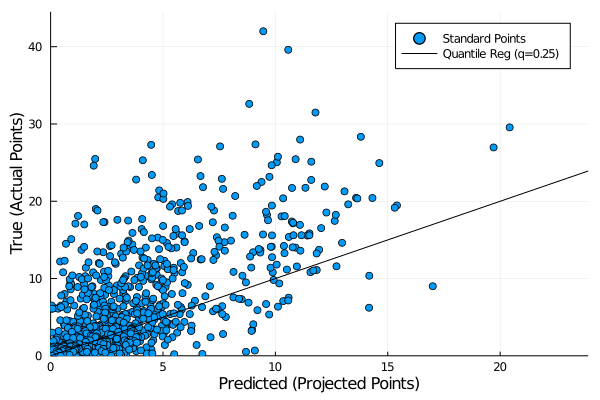

In [59]:
plot_pred_true(test_pred, test_std)